# Introduction

This is my take on the infamous [Titanic competition](https://www.kaggle.com/competitions/titanic).
We are given two datasets `train` and `test` containing passenger information. The goal is to achieve maximum **accuracy** while predicting if the passengers listed in `test` survived or not. Thus we have a classification problem. 

<div style="width:100%;text-align: center;"> <img align=middle src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Titanic_Structure.jpg" alt="Heat beating" style="height:300px;margin-top:1rem;margin-bottom:1rem;"> </div>

<a id="ToC"></a>
## Table of contents
* [1. Data preparation](#1)  
  * [1.1 Libraries and settings](#1.1)
  * [1.2 Data reading](#1.2)
  * [1.3 Data cleaning](#1.3)
      * [1.3.1 Age](#1.3.1)
      * [1.3.2 Cabin](#1.3.2)
      * [1.3.3 Embarked](#1.3.3)
      * [1.3.4 Fare](#1.3.4)
* [2. Exploratory data analysis (EDA)](#2)
  * [2.1 Univariate analysis](#2.1)
  * [2.2 Multivariate analysis](#2.2)
* [3. Data modeling](#3)
* [4. Conclusion](#4)

<a id="1"></a>
# 1. Data preparation
[ToC](#ToC) | [Next](#1.1)

In this section relevant libraries and settings used are listed, different datasets are read and missing data is handled according to a preliminary analysis.

<a id="1.1"></a> 
## 1.1 Libraries and settings
[Previous](#1) | [ToC](#ToC) | [Next](#1.2)

All imports and settings used throughout the study are listed in the cell below.

In [1]:
# Data wrangling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

custom_params = {
    "axes.spines.right": False, 
    "axes.spines.top": False,
    "patch.force_edgecolor": True,
}
sns.set_theme(
    context = "notebook",
    style = 'ticks',
    palette = 'viridis',
    font_scale = 1.25,
    rc = custom_params,
)

# Dataset paths
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


<a id="1.2"></a> 
## 1.2 Data reading
[Previous](#1.1) | [ToC](#ToC) | [Next](#1.3)

The datasets considered in this study are:
* `train` (from *train.csv*): training set, containing information from passengers that we know they survived;
* `test` (from *test.csv*): test set, containing information from passengers we want to guess if they survived or not.

Another dataset `gender_submission` is only included to exemplify our output format.

The datasets are loaded into their respective dataframes, using their unique `PassengerId` as index.

The `train` dataframe has 891 entries and 12 columns. Some of the columns (`Age`, `Cabin` and `Embarked`) have missing values that will need to be handled. The `test` dataframe contains 418 entries. As expected,`test` has the same columns as `train` except `Survived`. There are missing values in columns `Age`, `Fare` and `Cabin`.

The competition documentation have data dictionaries for the columns `Survived`, `Pclass` and `Embarked`. Mapping corresponding values using suffix `_x` to corresponding column name adds three columns to the `train` dataframe that will later be used to better label our data during EDA.

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
train.name = 'train'

test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')
test.name = 'test'

gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv', index_col='PassengerId')
gender_submission.name = 'gender submission'

both = [train, test] # Useful when needing to call or transform both datasets

def dataframe_summary():
    "Prints a summary for both datasets"
    for df in both:
        print(f"'{df.name}' dataframe summary:")
        print(f"Is '{df.name}' dataframe index unique? {df.index.is_unique}")
        df.info(memory_usage=False)
        print('\n')
dataframe_summary()
    
# Data dictionaries, useful when visualizing data
data_dictionaries = {
    'Survived': {0:'Perished', 1:'Survived'},
    'Pclass': {1:'1st', 2:'2nd', 3:'3rd'},
    'Embarked': {'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'}
}

# Apply data dictionary to 'train' to facilitate understanding
for column, dictionary in data_dictionaries.items():
    train[column+'_x'] = train.loc[~train[column].isnull(), column].apply(lambda x: dictionary[x])
    
print("'train' dataframe:")
train.head()

'train' dataframe summary:
Is 'train' dataframe index unique? True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)

'test' dataframe summary:
Is 'test' dataframe index unique? True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null  

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_x,Pclass_x,Embarked_x
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Perished,3rd,Southampton
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived,1st,Cherbourg
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived,3rd,Southampton
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived,1st,Southampton
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Perished,3rd,Southampton


<a id="1.3"></a> 
## 1.3 Data cleaning
[Previous](#1.2) | [ToC](#ToC) | [Next](#1.3.1)

We have four columns that have missing values in either dataframe. For each column we will make a preliminary exploration and decide how we will handle these values in both dataframes. We will use solely information from `train` dataframe to avoid data leakage.

The cell below contains some helper functions that will help us summarize data, replace missing values and plot histograms and boxplots during data cleaning stage.

In [3]:
def summarize(column_name: str) -> None:
    """
    Given a column name, print column null count for both dataframes.
    Then give a statistical summary for this column on train dataframe
    """
    for df in both:
        print(
            f"There are {df[column_name].isnull().sum()}/{df.shape[0]} " 
            f"null values in column '{column_name}' of '{df.name}' dataframe."
        )
    print(f"\nStatistical summary for '{column_name}' series in 'train' dataframe:")
    print(train[column_name].describe(), '\n')
    
def histogram_and_boxplot(column_name: str, ceiling=float('inf')) -> None:
    """
    Given a column name, return a grid showing a histogram for total count distribution
    and a boxplot highlighting median and outliers for passengers divided by survival.
    
    If a custom ceiling value is given, our plots will consider the fraction of the data
    up to ceiling value.
    """
    # Set figure grid
    fig, axes = plt.subplots(
        nrows = 2,
        ncols = 1, 
        sharex = True, 
        figsize = (10,6),
        gridspec_kw = dict(height_ratios=[2,1])
    )
    # Set suptitle to right align and position it in the top right corner
    title = f"{column_name} distribution in training data"
    title += f' (<= {ceiling})' if ceiling != float('inf') else ''
    fig.suptitle(
        title,
        ha = 'right',
        x = 0.95,
        y = 1,
    )
    if ceiling != float('inf'):
        plt.setp(axes, xlim =(0, ceiling))
        
    # Use tight layout to plot more cleanly
    fig.tight_layout()
    fig.subplots_adjust(top=1)
    
    # Get non NA points for column_name
    train_dropna = train[train[column_name].notnull()]
    
    # Select custom pallete, width and color for lines
    palette = dict(Perished='lightcoral', Survived='lightgreen')
    edgecolor = 'k'
    linewidth = 1
    
    # Boxplot
    boxes = sns.boxplot(
        data = train_dropna,
        x = column_name,
        y = 'Survived_x',
        hue = 'Survived_x',
        ax = axes[1],
        saturation = 1,
        palette = palette,
        linewidth = linewidth,
        dodge = False,
        boxprops = dict(edgecolor=edgecolor),
        medianprops = dict(color=edgecolor),
        whiskerprops = dict(color=edgecolor),
        flierprops = dict(markerfacecolor=edgecolor),
        capprops = dict(color=edgecolor),
    )
    # Boxpot style options
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[1].spines[['left', 'bottom']].set_visible(False)
    axes[1].legend([],[],frameon=False) # Remove legend
    
    # Annotate median value according to survivability
    medians = train_dropna.groupby('Survived_x')[column_name].median()
    for i in range(len(medians)):
        boxes.annotate(
            f' {medians[i]:.1f}',
            xy = (medians[i], i),
            ha = 'left',
            va = 'center',
        )    
    # Get legend information to be transported to histogram and format its line
    handles, labels = axes[1].get_legend_handles_labels()
    for handle in handles:
        handle.set_edgecolor(edgecolor)
        handle.set_linewidth(1)
    
    # Histogram plot
    sns.histplot(
        data = train_dropna,
        x = column_name,
        hue = 'Survived_x',
        multiple = 'stack',
        stat = 'count',
        ax = axes[0],
        edgecolor = edgecolor,
        alpha = 1,
        palette = palette,
    )
    axes[0].get_yaxis().set_visible(False)
    axes[0].spines[['left']].set_visible(False)
    axes[0].tick_params(labelbottom=True)
    
    # Annotate median on histogram
    median = train_dropna[column_name].median()
    axes[0].axvline(
        x = median,
        c = edgecolor,
        label = 'Median',
        ls = 'dashed',
        lw = 1.25,
        ymax = 0.95,
    )
    axes[0].text(
        x = median,
        y = 0.95,
        s = f' {median:.1f}',
        ha = 'left',
        va = 'top',
        transform=axes[0].get_xaxis_transform(),
    )
    # Get median line information and updata label
    h, l = axes[0].get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
    axes[0].legend(
        handles, labels,
        bbox_to_anchor = (1, 0.9), 
        frameon = False,
        edgecolor = edgecolor,
    )
    fig.show()
    
def replace_na_by_median(column_name:str) -> None:
    "Replaces missing values in given column using 'train' median."
    for df in both:
        df.loc[df[column_name].isnull(), [column_name]] = train[column_name].median()

<a id="1.3.1"></a>
### 1.3.1 Age
[Previous](#1.3) | [ToC](#ToC) | [Next](#1.3.2)

In order to study `Age` distribution we consider its summary statistics and two plots. The first plot is a stacked histogram and the second is a boxplot. It might be interesting to evaluate how `Age` is distributed if we were to divided the entries into groups of those who survived and those who perished.

The `Age` stacked histogram shows a roughly bimodal normal distribution slightly right-skewed.
The boxplot evidentiate that the median age remains 28 regardless of the survivability group. It also highlights the outliers are concentrated among the oldest passengers for each group.

In order to preserve the distribution shape, we can use the `train` median as a fill value for missing `Age` values. We are using the median and not the mean because the median is a more reliable center measure when the distribution is skewed.

There are 177/891 null values in column 'Age' of 'train' dataframe.
There are 86/418 null values in column 'Age' of 'test' dataframe.

Statistical summary for 'Age' series in 'train' dataframe:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64 



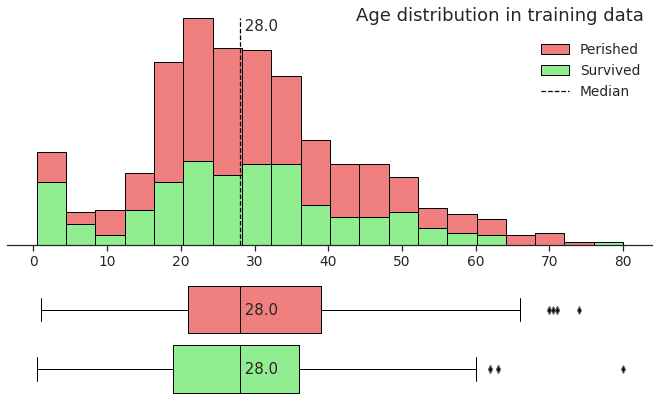

In [4]:
summarize('Age')
histogram_and_boxplot('Age')
replace_na_by_median('Age')

<a id="1.3.2"></a>
### 1.3.2 Cabin
[Previous](#1.3.1) | [ToC](#ToC) | [Next](#1.3.3)

The majority of values in `Cabin` column is missing in both dataframes. Two observations can be made:
1. If we grouped missing values in a category (say `missing`), this category would represent the majority of cases. 
2. Looking at the frequency of unique non-missing values we see they are too numerous and each have a very small frequency. The most frequent unique values have a frequency of 4.

An approach could be consider missing values as a category and transform `Cabin` into frequncy categories (frequent/infrequent). But observations 1 and 2 combined would result in a very biased and noninformative feature.

Thus, we opt not to include `Cabin` information in our study.

In [5]:
summarize('Cabin')
for df in both:
    df.drop('Cabin', axis='columns', inplace=True)

There are 687/891 null values in column 'Cabin' of 'train' dataframe.
There are 327/418 null values in column 'Cabin' of 'test' dataframe.

Statistical summary for 'Cabin' series in 'train' dataframe:
count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object 



<a id="1.3.3"></a>
### 1.3.3 Embarked
[Previous](#1.3.2) | [ToC](#ToC) | [Next](#1.3.4)

There are only 2 missing values in `train` dataframe. As this is a very small portion of data, we choose to ignore these two entries moving forward.

In [6]:
summarize('Embarked')
train.dropna(subset=['Embarked'], inplace=True)

There are 2/891 null values in column 'Embarked' of 'train' dataframe.
There are 0/418 null values in column 'Embarked' of 'test' dataframe.

Statistical summary for 'Embarked' series in 'train' dataframe:
count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object 



<a id="1.3.4"></a>
### 1.3.4 Fare
[Previous](#1.3.3) | [ToC](#ToC) | [Next](#2)

There's a single missing `Fare` value in `test` dataframe. Despite the maximum `Fare` value being 512, in order to better analyse the distribution shape, we opt to partialy plot fares up to 125. We have outliers going up to 512, but our interval of interest concentrates all major .

The partial `Fare` stacked histogram shows a unimodal distribution heavily right-skewed.
The boxplot evidentiate that the distribution of passengers who perished compared to those who survived have a smaller median and a more concentrated IQR.

We will treat the missing `Fare` value in `test` as we did for the missing `Age` values, replacing missing values with the median of all passengers.

There are 0/889 null values in column 'Fare' of 'train' dataframe.
There are 1/418 null values in column 'Fare' of 'test' dataframe.

Statistical summary for 'Fare' series in 'train' dataframe:
count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64 



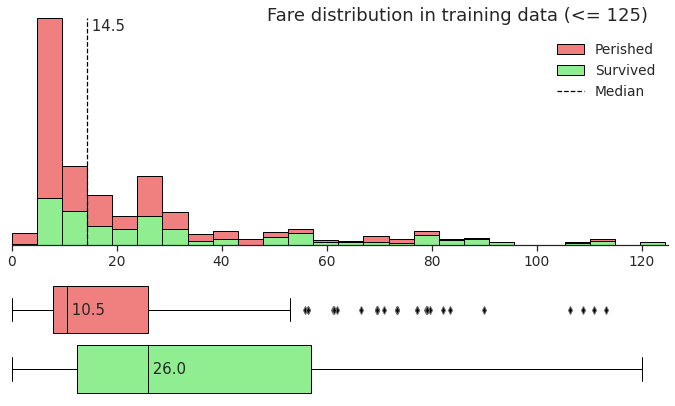

In [7]:
summarize('Fare')
histogram_and_boxplot('Fare', 125)
replace_na_by_median('Fare')

<a id="2"></a>
# 2. Exploratory data analysis (EDA)
[Previous](#1.3.4) | [ToC](#ToC) | [Next](#2.1)

From `train` dataset we make a primary selection of 7 features besides our prediction target `Survived`. In order to make EDA as readable as possible we are going to use the translated features with suffix `_x`. For modeling purposes we will use their original values.

In the following sections we are going to make univariate and multivariate analysis. We are going to discuss any detection of associated features.

In [8]:
primary_features = ['Sex', 'Age', 'Embarked', 'SibSp', 'Parch', 'Fare', 'Pclass']
primary_target = ['Survived_x']
train[primary_target + primary_features].head()

,Survived_x,Sex,Age,Embarked,SibSp,Parch,Fare,Pclass
PassengerId,,,,,,,,
1,Perished,male,22.0,S,1,0,7.2500,3
2,Survived,female,38.0,C,1,0,71.2833,1
3,Survived,female,26.0,S,0,0,7.9250,3
4,Survived,female,35.0,S,1,0,53.1000,1
5,Perished,male,35.0,S,0,0,8.0500,3


<a id="2.1"></a> 
## 2.1 Univariate analysis
[Previous](#2) | [ToC](#ToC) | [Next](#2.2)

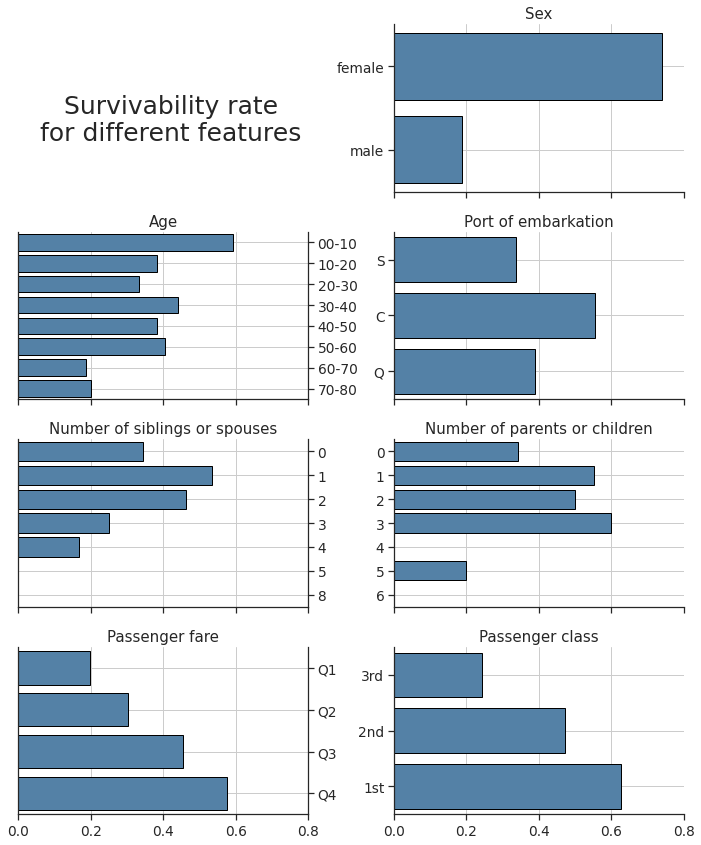

In [9]:
configuration = {
    'Sex': ('Sex', False, ['female', 'male']),
    'Age': ('Age', True, None),
    'Pclass': ('Passenger class', True, ['3rd', '2nd', '1st']),
    'SibSp': ('Number of siblings or spouses', False, None),
    'Parch': ('Number of parents or children', False, None),
    'Fare': ('Passenger fare', True, None), 
    'Embarked': ('Port of embarkation', False, None),
}

def univariate(column_name: str, ax, right_side) -> None:
    'Returns survivability rate for different features'
    
    # Choose if we are going to use the translated column
    y = column_name
    if configuration[column_name][1]:
        y += '_x'
    
    sns.barplot(
        ax = ax,
        data = train,
        x = 'Survived',
        y = y,
        order = configuration[column_name][2],
        color = 'steelblue',
        edgecolor = 'k',
        orient = 'h',
        ci = None,
    ).set(
        title = configuration[column_name][0],
        xlabel = None,
        ylabel = None,
    )
    if right_side: # Rotate y labels and axis for odd numbered axis
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.spines[['right']].set_visible(True)
    ax.grid()
    plt.tight_layout()
    
# Stratify both Age and Fare in order to analyse them
train['Age_x'] = pd.cut(
    train.Age, 
    list(range(0,90,10)),
    labels = [f'{i}0-{i+1}0' for i in range(8)],
)
train['Fare_x'] = pd.qcut(
    train.Fare, 
    q = 4, 
    labels = ['Q1', 'Q2', 'Q3', 'Q4'],
)

# Set figure grid
fig, axes = plt.subplots(
    nrows = 4,
    ncols = 2, 
    sharex = True, 
    figsize = (10,12),
)
axes = axes.flatten() # Make axes array one dimensional
axes[0].set_xlim([0, 0.8])
fig.delaxes(axes[0]) # Make space for title

# Title
fig.text(
    x = 0.25, 
    y = 0.85,
    s = "Survivability rate\nfor different features",
    ha="center", 
    va="center", 
    size=25,
)

# Fill grid with primary features univariate plots
for i, feature in enumerate(primary_features):
    univariate(feature, axes[i+1], bool(i % 2))

<a id="2.2"></a> 
## 2.2 Multivariate analysis
[Previous](#2.1.7) | [ToC](#ToC) | [Next](#3)

<a id="3"></a>
# 3. Data modeling
[Previous](#2.2) | [ToC](#ToC) | [Next](#4)

WIP

<a id="4"></a>
# 4. Conclusion
[Previous](#3) | [ToC](#ToC) | [Next](#4)

WIP